# Random Forest
Author: Javier Pelegrin Garcia

Date: 15/05/2023

This notebook is an approach to the analysis of peptide data detected with mass spectrometry.

The purpose of these models is to predict the charge of peptides

To run this notebook it is necessary to run <a href="./main.ipynb">Main</a> first.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from pyteomics import mass
from pyteomics import electrochem

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error

from utils.parseData import mz_to_mass
from utils.parseData import count_basic_residues
from utils.parseData import gererate_dic
from utils.parseData import PROTON_MASS
from utils.parseData import adjacent_values
from utils.parseData import set_axis_style
from utils.parseData import PH
from utils.parseData import find_peptide

def find_peptide(dic, condition):
    for i in dic.keys():
        for k in dic[i].keys():
            if k != 'total':
                if eval(condition):
                    print(i, dic[i])
                    return dic[i]


import joblib

IS_TRAINED_2 = True
IS_TRAINED_3 = True 
IS_TRAINED   = True

# laad de data
dic = joblib.load('data/dic.pkl')

#load the model
try:
    modele_rf_2 = joblib.load('models/model_rf_pc_2.rdf')
    modele_rf_3 = joblib.load('models/model_rf_pc_3.rdf')
    modele_rf   = joblib.load('models/model_rf_pc.rdf')
except:
    pass

# Model with data less than 100% persentage

In [2]:
def generate_data(dic, min_mass=0, max_mass=np.inf, min_charge=0, max_charge=np.inf, min_residues=0, max_residues=np.inf):
    mass = []
    residues = []
    charge = []
    mass = []
    persentage = []
    labels = []

    for i in dic.keys():
        for j in dic[i].keys():
            if j != 'total':
                if dic[i][j]['%'] < 1 and electrochem.charge(dic[i][j]['sequence'], pH=PH) > min_charge and electrochem.charge(dic[i][j]['sequence'], pH=PH) < max_charge and dic[i][j]['Masse'] > min_mass and dic[i][j]['Masse'] < max_mass and count_basic_residues(dic[i][j]['sequence']) > min_residues and count_basic_residues(dic[i][j]['sequence']) < max_residues: 
                    mass.append(dic[i][j]['Mass_excel'])
                    residues.append(count_basic_residues(dic[i][j]['sequence']))
                    charge.append(electrochem.charge(dic[i][j]['sequence'], pH=PH))
                    persentage.append(dic[i][j]['%'])
                    labels.append(j)
    
    return mass, residues, charge, persentage, labels

mass, residues, charge, persentage, labels  = generate_data(dic, min_charge=2)

def shuffle(l1, l2):
    temp = list(zip(l1, l2))
    random.shuffle(temp)
    res1, res2 = zip(*temp)
    res1, res2 = np.array(res1), np.array(res2)
    return res1, res2

x_train = np.array([ [m, r, c,p] for m, r, c, p in zip(mass, residues, charge, persentage) ])
y_train = np.array(labels)
print(x_train.shape, y_train.shape)
x_test = []
y_test = []

for _ in range(10):
    x_train, y_train = shuffle(x_train, y_train)

for i in range(round(x_train.shape[0]*0.25)):
    x_test.append(x_train[i])
    x_train = np.delete(x_train, i, 0)
    y_test.append(y_train[i])
    y_train = np.delete(y_train, i)

x_test = np.array(x_test)
y_test = np.array(y_test)
y_test = (y_test).round().astype(int)
y_train = (y_train).round().astype(int)

y_test_2 = y_test.copy()
x_test_2 = x_test.copy()

# Affichage du nombre d'exemples totales dans le corpus
print('Total corpus size')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus 
print('\nTraining data size')
print('\t• X_train (masse,residues,charge):', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTest data size')
print('\t• X_test (masse,residues,charge) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

(4786, 4) (4786,)
Total corpus size
	• train : 3590 exemples
	• test : 1196 exemples

Training data size
	• X_train (masse,residues,charge): (3590, 4)
	• y_train (labels) : (3590,)

Test data size
	• X_test (masse,residues,charge) : (1196, 4)
	• y_test (labels) : (1196,)


In [3]:
if not IS_TRAINED_2:
    modele_rf_2 = RandomForestClassifier(n_estimators=10000, max_depth=10 ,random_state=123, min_samples_split=20, criterion='gini', min_samples_leaf=5, bootstrap=True, n_jobs=6, warm_start=True)
    modele_rf_2.fit(x_train, y_train)
    joblib.dump(modele_rf_2, 'models/model_rf_pc_2.rdf')

In [4]:
y_pred_2 = modele_rf_2.predict(x_test)

RMSE: 0.43661819877899816


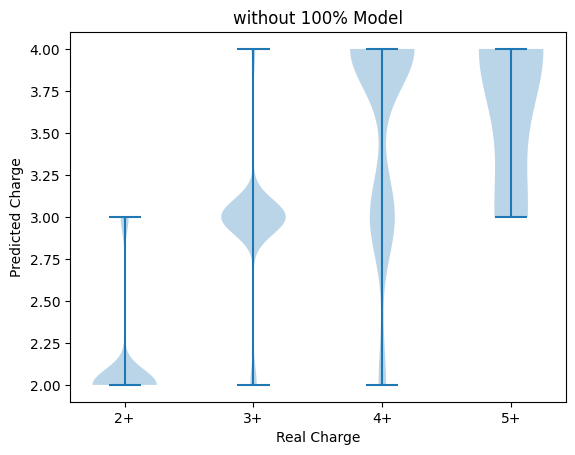

In [5]:
y_pred = [[],[],[],[]]
for i,elem in enumerate(y_test_2):
    y_pred[elem-2].append(y_pred_2[i])

print(f'RMSE: {mean_squared_error(y_test_2, y_pred_2, squared=False)}')
plt.violinplot(y_pred)
plt.xticks([1,2,3,4],['2+','3+','4+','5+'])
plt.xlabel('Real Charge')
plt.ylabel('Predicted Charge')
plt.title('without 100% Model')
plt.show()

In [6]:
find_peptide(dic,"k == 5 and dic[i][k]['%'] == 1")

mass = dic[2283124][5]['Mass_excel']
charge = electrochem.charge(dic[2283124][5]['sequence'], pH=PH)
residues = count_basic_residues(dic[2283124][5]['sequence'])
persentage = dic[2283124][5]['%']

print(f"\tpredicted charge: {modele_rf_2.predict(np.array([mass,charge,residues,persentage]).reshape(1,-1))[0]}")
print(f"\treal charge: {5}\n")

find_peptide(dic,"k == 5 and dic[i][k]['%'] != 1")
mass = dic[2278144][5]['Mass_excel']
charge = electrochem.charge(dic[2278144][5]['sequence'], pH=PH)
residues = count_basic_residues(dic[2278144][5]['sequence'])
persentage = dic[2278144][5]['%']

print(f"\tpredicted charge: {modele_rf_2.predict(np.array([mass,charge,residues,persentage]).reshape(1,-1))[0]}")
print(f"\treal charge: {5}")



2283124 {5: {'sequence': 'GINLSSGDQNLAPEIGMQEIALHSGEEPHAEEHLK', 'abundance': 9555105, 'ion_moz': 750.965576171875, 'master_quant_peptide_ion_id': 333956, '%': 1.0, 'Masse': 2755.455613044792, 'Mass_excel': 3749.791500859375}, 'total': 9555105}
	predicted charge: 4
	real charge: 5

2278144 {3: {'sequence': 'RPHDYQPLPGMSENPSVYVPGVVSTVVPDSAHK', 'abundance': 7139863, 'ion_moz': 1187.26123046875, 'master_quant_peptide_ion_id': 309780, '%': 0.07933857163895444, 'Masse': 4458.445142376894, 'Mass_excel': 3558.76186340625}, 4: {'sequence': 'RPHDYQPLPGMSENPSVYVPGVVSTVVPDSAHK', 'abundance': 41001440, 'ion_moz': 890.6973266601562, 'master_quant_peptide_ion_id': 309781, '%': 0.4556103786221517, 'Masse': 3343.832296317391, 'Mass_excel': 3558.760202640625}, 5: {'sequence': 'RPHDYQPLPGMSENPSVYVPGVVSTVVPDSAHK', 'abundance': 41851028, 'ion_moz': 712.7586669921875, 'master_quant_peptide_ion_id': 309782, '%': 0.4650510497388939, 'Masse': 2675.063395822561, 'Mass_excel': 3558.7569549609375}, 'total': 89992

# Model with data 100% include

In [7]:
def generate_data(dic, min_mass=0, max_mass=np.inf, min_charge=0, max_charge=np.inf, min_residues=0, max_residues=np.inf):
    mass = []
    residues = []
    charge = []
    mass = []
    persentage = []
    labels = []

    for i in dic.keys():
        for j in dic[i].keys():
            if j != 'total':
                if electrochem.charge(dic[i][j]['sequence'], pH=PH) > min_charge and electrochem.charge(dic[i][j]['sequence'], pH=PH) < max_charge and dic[i][j]['Masse'] > min_mass and dic[i][j]['Masse'] < max_mass and count_basic_residues(dic[i][j]['sequence']) > min_residues and count_basic_residues(dic[i][j]['sequence']) < max_residues: 
                    mass.append(dic[i][j]['Mass_excel'])
                    residues.append(count_basic_residues(dic[i][j]['sequence']))
                    charge.append(electrochem.charge(dic[i][j]['sequence'], pH=PH))
                    persentage.append(dic[i][j]['%'])
                    labels.append(j)
    
    return mass, residues, charge, persentage, labels

mass, residues, charge, persentage, labels  = generate_data(dic, min_charge=2)

def shuffle(l1, l2):
    temp = list(zip(l1, l2))
    random.shuffle(temp)
    res1, res2 = zip(*temp)
    res1, res2 = np.array(res1), np.array(res2)
    return res1, res2

x_train = np.array([ [m, r, c,p] for m, r, c, p in zip(mass, residues, charge, persentage) ])
y_train = np.array(labels)
print(x_train.shape, y_train.shape)
x_test = []
y_test = []

for _ in range(10):
    x_train, y_train = shuffle(x_train, y_train)

for i in range(round(x_train.shape[0]*0.25)):
    x_test.append(x_train[i])
    x_train = np.delete(x_train, i, 0)
    y_test.append(y_train[i])
    y_train = np.delete(y_train, i)

x_test = np.array(x_test)
y_test = np.array(y_test)
y_test = (y_test).round().astype(int)
y_train = (y_train).round().astype(int)

y_test_3 = y_test.copy()
x_test_3 = x_test.copy()

# Affichage du nombre d'exemples totales dans le corpus
print('Total corpus size')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus 
print('\nTraining data size')
print('\t• X_train (masse,residues,charge):', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTest data size')
print('\t• X_test (masse,residues,charge) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

(11635, 4) (11635,)
Total corpus size
	• train : 8726 exemples
	• test : 2909 exemples

Training data size
	• X_train (masse,residues,charge): (8726, 4)
	• y_train (labels) : (8726,)

Test data size
	• X_test (masse,residues,charge) : (2909, 4)
	• y_test (labels) : (2909,)


In [8]:
if not IS_TRAINED_3:
    modele_rf_3 = RandomForestClassifier(n_estimators=10000, max_depth=10 ,random_state=123, min_samples_split=20, criterion='gini', min_samples_leaf=5, bootstrap=True, n_jobs=6, warm_start=True)
    modele_rf_3.fit(x_train, y_train)
    joblib.dump(modele_rf_3, 'models/model_rf_pc_3.rdf')

In [9]:
y_pred_3 = modele_rf_2.predict(x_test)

RMSE: 0.4859666965065004


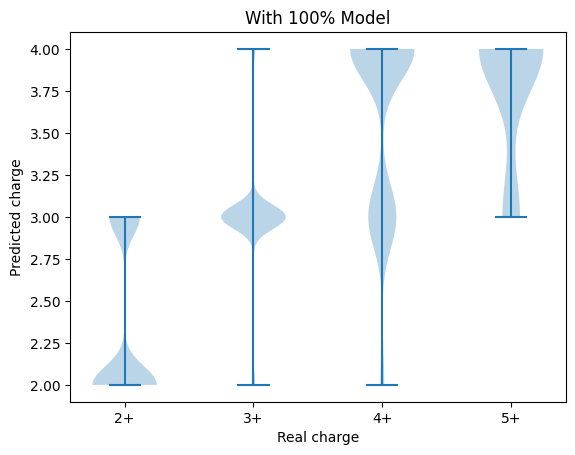

In [10]:
y_pred = [[],[],[],[]]
for i,elem in enumerate(y_test_3):
    y_pred[elem-2].append(y_pred_3[i])

print(f'RMSE: {mean_squared_error(y_test_3,y_pred_3, squared=False)}')
plt.violinplot(y_pred)
plt.xticks([1,2,3,4],['2+','3+','4+','5+'])
plt.xlabel('Real charge')
plt.ylabel('Predicted charge')
plt.title('With 100% Model')
plt.show()

# Model without persentage in data

In [11]:
def generate_data(dic, min_mass=0, max_mass=np.inf, min_charge=0, max_charge=np.inf, min_residues=0, max_residues=np.inf):
    mass = []
    residues = []
    charge = []
    mass = []
    persentage = []
    labels = []

    for i in dic.keys():
        for j in dic[i].keys():
            if j != 'total':
                if electrochem.charge(dic[i][j]['sequence'], pH=PH) > min_charge and electrochem.charge(dic[i][j]['sequence'], pH=PH) < max_charge and dic[i][j]['Masse'] > min_mass and dic[i][j]['Masse'] < max_mass and count_basic_residues(dic[i][j]['sequence']) > min_residues and count_basic_residues(dic[i][j]['sequence']) < max_residues: 
                    mass.append(dic[i][j]['Mass_excel'])
                    residues.append(count_basic_residues(dic[i][j]['sequence']))
                    charge.append(electrochem.charge(dic[i][j]['sequence'], pH=PH))
                    persentage.append(dic[i][j]['%'])
                    labels.append(j)
    
    return mass, residues, charge, persentage, labels

mass, residues, charge, persentage, labels  = generate_data(dic, min_charge=2)

def shuffle(l1, l2):
    temp = list(zip(l1, l2))
    random.shuffle(temp)
    res1, res2 = zip(*temp)
    res1, res2 = np.array(res1), np.array(res2)
    return res1, res2

x_train = np.array([ [m, r, c] for m, r, c in zip(mass, residues, charge) ])
y_train = np.array(labels)
print(x_train.shape, y_train.shape)
x_test = []
y_test = []

for _ in range(10):
    x_train, y_train = shuffle(x_train, y_train)

for i in range(round(x_train.shape[0]*0.25)):
    x_test.append(x_train[i])
    x_train = np.delete(x_train, i, 0)
    y_test.append(y_train[i])
    y_train = np.delete(y_train, i)

x_test = np.array(x_test)
y_test = np.array(y_test)
y_test = (y_test).round().astype(int)
y_train = (y_train).round().astype(int)

y_test_ = y_test.copy()
x_test_ = x_test.copy()

# Affichage du nombre d'exemples totales dans le corpus
print('Total corpus size')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus 
print('\nTraining data size')
print('\t• X_train (masse,residues,charge):', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTest data size')
print('\t• X_test (masse,residues,charge) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

(11635, 3) (11635,)
Total corpus size
	• train : 8726 exemples
	• test : 2909 exemples

Training data size
	• X_train (masse,residues,charge): (8726, 3)
	• y_train (labels) : (8726,)

Test data size
	• X_test (masse,residues,charge) : (2909, 3)
	• y_test (labels) : (2909,)


In [12]:
if not IS_TRAINED:
    modele_rf = RandomForestClassifier(n_estimators=10000, max_depth=10 ,random_state=123, min_samples_split=20, criterion='gini', min_samples_leaf=5, bootstrap=True, n_jobs=6, warm_start=True)
    modele_rf.fit(x_train, y_train)
    joblib.dump(modele_rf, 'models/model_rf_pc.rdf')

In [15]:
y_pred_ = modele_rf.predict(x_test)

RMSE: 0.5534354719280059


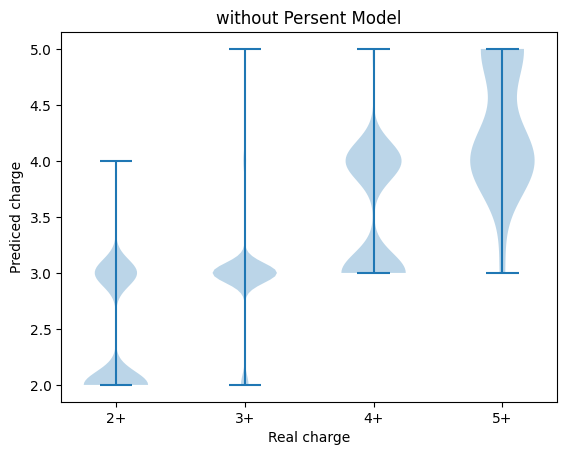

In [16]:
y_pred = [[],[],[],[]]
for i,elem in enumerate(y_test_):
    y_pred[elem-2].append(y_pred_[i])

print(f'RMSE: {mean_squared_error(y_test, y_pred_, squared=False)}')
plt.violinplot(y_pred)
plt.xticks([1,2,3,4],['2+','3+','4+','5+'])
plt.xlabel('Real charge')
plt.ylabel('Prediced charge')
plt.title('without Persent Model')
plt.show()

In [13]:
find_peptide(dic,"dic[i][k]['%'] >= 1 and k == 2")

2379 {2: {'sequence': 'QLSEILR', 'abundance': 7166869.5, 'ion_moz': 429.75323486328125, 'master_quant_peptide_ion_id': 351243, '%': 1.0, 'Masse': 482.88129853829713, 'Mass_excel': 857.4919177265625}, 'total': 7166869.5}


{2: {'sequence': 'QLSEILR',
  'abundance': 7166869.5,
  'ion_moz': 429.75323486328125,
  'master_quant_peptide_ion_id': 351243,
  '%': 1.0,
  'Masse': 482.88129853829713,
  'Mass_excel': 857.4919177265625},
 'total': 7166869.5}

In [14]:
print(dic[2379])
mass = dic[2379][2]['Mass_excel']
charge = electrochem.charge(dic[2379][2]['sequence'], pH=PH)
residues = count_basic_residues(dic[2379][2]['sequence'])
persentage = dic[2379][2]['%']

print(f"mass: {mass}, charge: {charge}, residues: {residues}")

print(modele_rf.predict(np.array([mass,charge,residues]).reshape(1,-1)))
print(modele_rf_2.predict(np.array([mass,charge,residues,persentage]).reshape(1,-1)))
print(modele_rf_3.predict(np.array([mass,charge,residues,persentage]).reshape(1,-1)))


{2: {'sequence': 'QLSEILR', 'abundance': 7166869.5, 'ion_moz': 429.75323486328125, 'master_quant_peptide_ion_id': 351243, '%': 1.0, 'Masse': 482.88129853829713, 'Mass_excel': 857.4919177265625}, 'total': 7166869.5}
mass: 857.4919177265625, charge: 1.1262643730066704, residues: 1
[2]
[3]
[2]


_____________


In [10]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import random
from pyteomics import mass
from pyteomics import electrochem

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error

import joblib


In [11]:
__path_model__ = r"D:\dev\LCMSMS_Pred_Supplemental_Material_section_S6\ChargeState\zfit_bidirLSTM2_masking_model.h5"
__DATA_1_PATH__ = r"D:\dev\Stats\data\dic.pkl"
__DATA_2_PATH__ = r"D:\dev\RT_STUDY\Quantified_peptide_ions.tsv"

In [18]:
dic = joblib.load(__DATA_1_PATH__)

def generate_data(dic):
    charge = []
    seq = []

    for i in dic.keys():
        for j in dic[i].keys():
            if j != 'total':
                charge.append(str(j))
                seq.append(dic[i][j]['sequence'])
    return np.array(seq),np.array(charge)

seq,charge = generate_data(dic)
print(len(seq),len(charge))

names = ''' peptide_id	sequence	modifications	master_elution_time	master_quant_peptide_ion_moz	master_quant_peptide_ion_charge	master_quant_peptide_ion_elution_time	master_quant_peptide_ion_feature_id	psm_count_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72878	psm_count_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72882	psm_count_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72898	psm_count_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72904	psm_count_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72907	psm_count_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72911	psm_count_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73324	psm_count_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73334	psm_count_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73344	psm_count_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73495	psm_count_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73500	psm_count_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73578	psm_count_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73592	psm_count_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73599	psm_count_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73622	psm_count_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73631	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72878	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72882	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72898	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72904	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72907	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72911	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73324	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73334	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73344	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73495	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73500	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73578	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73592	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73599	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73622	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73631	corrected_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72878	corrected_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72882	corrected_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72898	corrected_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72904	corrected_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72907	corrected_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72911	corrected_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73324	corrected_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73334	corrected_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73344	corrected_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73495	corrected_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73500	corrected_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73578	corrected_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73592	corrected_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73599	corrected_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73622	corrected_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73631	raw_abundance_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72878	raw_abundance_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72882	raw_abundance_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72898	raw_abundance_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72904	raw_abundance_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72907	raw_abundance_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72911	raw_abundance_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73324	raw_abundance_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73334	raw_abundance_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73344	raw_abundance_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73495	raw_abundance_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73500	raw_abundance_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73578	raw_abundance_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73592	raw_abundance_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73599	raw_abundance_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73622	raw_abundance_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73631'''

elution_time_new_file = '''elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72878	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72882	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72898	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72904	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72907	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72911	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73324	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73334	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73344	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73495	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73500	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73578	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73592	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73599	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73622	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73631'''

# elution_time_new_file = elution_time_new_file.replace(' ','_')
# elution_time_new_file = elution_time_new_file.replace('-','_')
elution_time_new_file = elution_time_new_file.split('\t')


labels = '''elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72878	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72882	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72898	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72904	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72907	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_72911	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73324	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73334	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73344	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73495	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73500	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73578	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73592	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73599	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73622	elution_time_MC HeLa Thermo MS60K-HCD15KG120 1ug ON 45C_73631	'''
labels = labels.replace('\t','_labels\t')
# labels = labels.replace('-','_')
# labels = labels.replace(' ','_')
labels = labels.split('\t')

df = pd.read_table(__DATA_2_PATH__, sep='\t', names=names.split('\t'))
df = df[1:]
df.head()

ions = np.array(df['master_quant_peptide_ion_charge'].values)
ions = np.concatenate((ions,charge))

seq1 = np.array(df['sequence'].values)
seq = np.concatenate((seq1,seq))

data = pd.DataFrame(list(zip(seq, ions)),
               columns =['seq', 'charge'])
print(data.shape)
data.head()
data['seq'].duplicated()

56571 56571
(121277, 2)


C:\Users\pelegrin\AppData\Local\Temp\ipykernel_18992\2456767834.py:32: DtypeWarning: Columns (0,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(__DATA_2_PATH__, sep='\t', names=names.split('\t'))


0         False
1         False
2         False
3         False
4         False
          ...  
121272     True
121273    False
121274     True
121275    False
121276    False
Name: seq, Length: 121277, dtype: bool

In [19]:
##Prediction of LCMSMS properties of peptides from sequence by deep learning
##Shenheng Guan1, Michael F. Moran, and Bin Ma
##2019-02-21

## MODIFIED BY JAVIER PELEGRIN GARCIA
##2023-07-28

import numpy as np



class InvalidPeptideLength(Exception):
    "Error peptide is too long."
    pass

class InvalidCharge(Exception):
    "Error charge is invalid."
    pass


psi_to_single_ptm = {'(Acetyl)-': 'B',
                     '(Carbamyl)': 'O',
                     '(Carbamidomethyl)': '',
                     'M(Oxidation)': 'J',
                     '(Gln->pyro-Glu)Q': 'X',
                     'N(Deamidated)': 'D',
                     'Q(Deamidated)': 'E'}

def reshapeOneHot(X):
    X = np.dstack(X)
    X = np.swapaxes(X, 1, 2)
    X = np.swapaxes(X, 0, 1)
    return X

def get_single_ptm_code(psi_sequence):
    sequence = psi_sequence
    for ptm in psi_to_single_ptm:
        sequence = sequence.replace(ptm, psi_to_single_ptm[ptm])
    return sequence

def one_hot_encode_peptide(psi_sequence, MAX_LENGTH = 41):
    peptide = get_single_ptm_code(psi_sequence)
    if len(peptide) > MAX_LENGTH:
        # print('Peptide length is larger than maximal length of ', str(MAX_LENGTH))
        raise InvalidPeptideLength
    else:
        AA_vocabulary = 'KRPTNAQVSGILCMJHFYWEDBXOU'#B: acetyl; O: Carbamyl; J: oxidized Met; X:pyro_glu
        no_not_used_aas = 2#U: not used

        one_hot_peptide = np.zeros((len(peptide), len(AA_vocabulary) - no_not_used_aas))

        # print(one_hot_peptide.shape,(len(peptide), len(AA_vocabulary) - no_not_used_aas))

        for j in range(0, len(peptide)):
            try:
                aa = peptide[j]
                one_hot_peptide[j, AA_vocabulary.index(aa)] = 1
            except:
                pass
        
        no_front_paddings = int((MAX_LENGTH - len(peptide))/2)
        peptide_front_paddings = np.zeros((no_front_paddings, one_hot_peptide.shape[1]))

        no_back_paddings = MAX_LENGTH - len(peptide) - no_front_paddings
        peptide_back_paddings = np.zeros((no_back_paddings, one_hot_peptide.shape[1]))

        full_one_hot_peptide = np.vstack((peptide_front_paddings, one_hot_peptide, peptide_back_paddings))

        return peptide, full_one_hot_peptide
    
def one_hot_encode_peptide_ion(psi_sequence, charge, MAX_LENGTH = 41, MAX_CHARGE = 6):

    if len(psi_sequence) >= MAX_CHARGE:
        raise InvalidPeptideLength

    peptide, full_one_hot_peptide = one_hot_encode_peptide(psi_sequence)
    
    one_hot_charge = np.zeros((len(peptide), MAX_CHARGE))
    one_hot_charge[:, charge - 1] = 1
    
    no_front_paddings = int((MAX_LENGTH - len(peptide))/2)
    charge_front_paddings = np.zeros((no_front_paddings, one_hot_charge.shape[1]))

    no_back_paddings = MAX_LENGTH - len(peptide) - no_front_paddings
    charge_back_paddings = np.zeros((no_back_paddings, one_hot_charge.shape[1]))

    full_one_hot_charge = np.vstack((charge_front_paddings, one_hot_charge, charge_back_paddings))

    full_one_hot_peptide_ion = np.hstack((full_one_hot_peptide, full_one_hot_charge))

    return full_one_hot_peptide_ion


def on_hot_encode_charge(charge,MAX_CHARGE = 5):
    if charge > MAX_CHARGE:
        raise InvalidCharge
    one_hot_charge = np.zeros((1, MAX_CHARGE))
    one_hot_charge[:, charge - 1] = 1
    return one_hot_charge

In [20]:
def pass_to_EncyclopeDIA_style(seq,mod):
    DIA = {
        "Carbamidomethyl" : ( "+57.021464", ("C")),
        "Oxidation": ("+15.99491" ,("M")),
        "Phosphorylation": ("+79.966331" ,("S", "T", "Y")),
        "Acetyl": ("+42.010565" ,("K", "N-term")),
        "Succinylation": ("+101.023869" ,("K")),
        "Ubiquitylation": ("+114.042927" ,("K")),
        "Mono-methylation": ("+14.015650" ,("K", "R")),
        "Di-methylation": ("+28.031300" ,("K", "R")),
        "Tri-methylation": ("+42.046950" ,("K")),
        "TMT0": ("+224.152478" ,("K", "N-term")),
        "TMT10": ("+229.162932" ,("K", "N-term")),
        "Pyroglutamate": ("-18.010565" ,("N-term E")),
        "Pyroglutamate": ("-17.026549" ,("N-term","Q")),
        "Cyclized S-CAM-Cys": ("+39.994915" ,("N-term", "C"))
    }
    mod = mod.split("|")
    
    new_seq = ""
    while len(mod) > 0:
        n = int(mod.pop(0))
        new_seq = f"{new_seq}{seq[:n]}[{DIA[mod.pop(0)][0]}]"
        seq = seq[n:]
    return f"{new_seq}{seq}"

In [21]:
class differentlenght(Exception):
    "List have differents length"
    pass

def normalize_data(list_seq, list_charge):
    occ = 0
    label, one_hot = [], []
    if len(list_seq) != len(list_charge):
        print(f"list of seq: {len(list_seq)} and list of charge: {len(list_charge)} have differents length.")
        raise differentlenght
    for seq,charge in zip(list_seq,list_charge):
        try:
            one_hot.append(one_hot_encode_peptide(seq)[1])
            label.append(on_hot_encode_charge(charge))
        except InvalidPeptideLength:
            print(f"peptide {seq} with length = {len(seq)} is too long, Max length is 41")
            occ+=1
            pass
        except InvalidCharge:
            print(f"peptide {seq} with charge = {charge} is invalid")
            one_hot.pop()
            pass
    print(f"peptides bigger than 41 = {occ}")
    return np.array(one_hot),np.array(label)

In [23]:
charge = []
for i in data['charge'].values:
    if type(i) == str: 
        i = eval(i)
    charge.append(i)

In [24]:
X,y = normalize_data( data['seq'].values, charge)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

peptide VGEPGHGGDPGLVSAYGAGLEGGVTGNPAEFVVNTSNAGAGALSVTIDGPSK with length = 52 is too long, Max length is 41
peptide PNTPVLMCSVPGYDASGHVEDLAAEQNTQITSIAIGSAEGFNQADK with length = 46 is too long, Max length is 41
peptide DADDNCVTVCNMENVDAMGVHTGDSVVVAPAQTLSNAEFQMLR with length = 43 is too long, Max length is 41
peptide GHMPPLTSAQQALTGTINSSMQAVQAAQATLDDFDTLPPLGQDAASK with length = 47 is too long, Max length is 41
peptide TAPSTNSSAPAVVGNPGVTEVSPEFLAALPPAIQEEVLAQQR with length = 42 is too long, Max length is 41
peptide EIDVDAVASDGVVAAIAISEHVENAGVHSGDATLVTPPQDITAK with length = 44 is too long, Max length is 41
peptide VVETDPSPYCIVAPDTVIHCEGEPIKREDEEESLNEVGYDDIGGCR with length = 46 is too long, Max length is 41
peptide SEEVPAFGVASPPPLTDTPDTTANAEGDLPTTMGGPLPPHLALK with length = 44 is too long, Max length is 41
peptide SEEVPAFGVASPPPLTDTPDTTANAEGDLPTTMGGPLPPHLALK with length = 44 is too long, Max length is 41
peptide QNQVGVVPWSPPQSNWNPWTSSNIDEGPLAFATPEQISMDLK with length = 42 is too long, Max len

In [27]:
import keras
from keras.models import load_model


model = load_model(__path_model__)


predict_charge = model.predict(X_test)

1250/1250 [==============================] - 189s 151ms/step


[1.9705666e-03 6.0132283e-01 3.7345380e-01 2.3251373e-02 1.3963582e-06]
RMSE: 0.4230419391042932


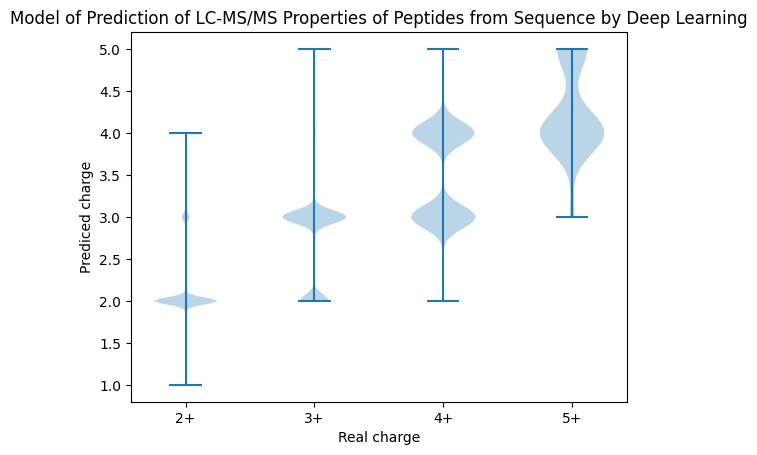

In [28]:
f = lambda x : np.argmax(x)+1
print(predict_charge[0])
predict_y = np.array(list(map(f,predict_charge)))

charge_y = np.array(list(map(f,y_test)))

y_pred = [[],[],[],[]]
for pred,real in zip(predict_y,charge_y):
    y_pred[real-2].append(pred)

# print(y_pred)
print(f'RMSE: {mean_squared_error(charge_y, predict_y, squared=False)}')
plt.violinplot(y_pred)
plt.xticks([1,2,3,4],['2+','3+','4+','5+'])
plt.xlabel('Real charge')
plt.ylabel('Prediced charge')
plt.title('Model of Prediction of LC-MS/MS Properties of Peptides from Sequence by Deep Learning')
plt.show()